# Energy-based Pointing Game

Cell directly below:
- iterates one model (e.g. best performing fold 1 model of B-Cos ResNet50)
- determines Energy-based pointing game of the fold fitting to the model (validation set) - first fold model focuses on validation set of first fold
- calculates average energy-based pointing game result of the validation set
- Results: higher proportion (result of energy-based pointing game) on correctly classified images

Second Cell below:
- prints image with corresponding explanation image
- executes Energy-based pointing game on one image - giving results

# Calculate EPG (Precision) for a singular model

In [2]:
from libraries.energyPointGame import energy_point_game
from libraries.ImageUtil import find_original_image_name
from libraries.bcosconv2d import NormedConv2d


import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

'''from dataset.pneumonia_dataset import PneumoniaDataset'''
from dataset.augmentations import no_augmentations
from libraries.bcosconv2d import NormedConv2d
#from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
#model_path = r"C:\Users\Admin\Documents\MasterThesis\results\Transformer_Conv_BCos\no_nosamp\seed_0\pneumonia_detection_model_transformer_bcos_bestf1_1.pth"
# model_path = r"C:\Users\Admin\Documents\MasterThesis\results\Pneumonia\ResNet50_BCos\light_oversamp\seed_0\pneumonia_detection_model_resnet_bestf1_1.pth"
model_path = r"C:\Users\Admin\Downloads\BCosResNet50_test\seed_0_1\pneumonia_detection_model_resnet_bestf1_1.pth"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = torch.hub.load('B-cos/B-cos-v2', 'vitc_b_patch1_14', pretrained=True)
#model[0].linear_head.linear = BcosLinear(in_features=768, out_features=2, bias=False, b=2)

model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

# Modify model and load model
'''model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)

model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)        
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
'''
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

model.to(device)


data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 
first_split = splits[0] # fold selection
val_idx = first_split[1]  # Only use the validation indices from the first fold
val_data = data_splits.iloc[val_idx]



def energy_point_game_debug(coords, contrib_map):
    num_positive = (contrib_map > 0).sum().item()
    num_negative = (contrib_map < 0).sum().item()
    
    print(f"Bounding Box Coordinates: {coords.tolist()}")
    print(f"Contribution Map Min/Max: {contrib_map.min().item()}, {contrib_map.max().item()}")
    print(f"Positive Values Count: {num_positive}, Negative Values Count: {num_negative}")
    
    result = energy_point_game(coords, contrib_map)
    print(f"Energy Point Game Score: {result}\n")
    
    return result

### alternative in new models
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()# Normalize with ImageNet stats
])


''' 
transform = no_augmentations() 
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)

'''
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

proportions = []
proportions_correct = []
proportions_incorrect = []
count_correct = 0
count_incorrect = 0
model.eval()
with torch.no_grad():
    for images, labels, patient_ids in val_loader:
        #images, labels = images.to(device), labels.to(device)
        labels = labels.to(device)
        six_channel_images = []
        for img_tensor in images:
            numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            pil_image = Image.fromarray(numpy_image)
            transformed_image = model.transform(pil_image)
            six_channel_images.append(transformed_image)
            
        six_channel_images = torch.stack(six_channel_images).to(device)
        
        for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
            filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
            if not filtered_rows.empty: 
                image = image[None]
                output = model(image)
                #print(image.shape)
                prediction = torch.argmax(output, dim=1)
                expl = model.explain(image)
                #prediction = expl['prediction']
                contribution_map = expl['contribution_map'].squeeze(0).cpu()
                #contribution_map = torch.clamp(contribution_map, min=0)
                contribution_map[contribution_map<0] = 0  
                proportion = 0.0
                for _, row in filtered_rows.iterrows():
                    x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                    #coordinates_list = [y, x, y + height,x + width]
                    coordinates_list = [x, y, x + width, y + height]
                    coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                    ebpg_result = energy_point_game(coordinates_tensor, contribution_map)
                    proportion += ebpg_result
                    
                proportions.append(proportion)
                if prediction == 1:
                    proportions_correct.append(proportion)
                    count_correct = count_correct + 1
                else:
                    proportions_incorrect.append(proportion)
                    count_incorrect = count_incorrect + 1
                

if proportions:
    avg_proportion = sum(proportions) / len(proportions)
    avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
    avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
    
    avg_proportion = round(avg_proportion.item(), 4)
    avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
    avg_proportion_correct = round(avg_proportion_correct.item(), 4)

    print(f"Average Energy-Based Pointing Game Proportion: {avg_proportion}")
    print(f"Average Energy-Based Pointing Game Proportion of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}")
    print(f"Average Energy-Based Pointing Game Proportion of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}")

else:
    print("No valid proportions were found.")





Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Average Energy-Based Pointing Game Proportion: 0.1046
Average Energy-Based Pointing Game Proportion of Incorrectly Classified Images: 0.0785, Count: 412
Average Energy-Based Pointing Game Proportion of Correctly Classified Images: 0.1182, Count: 790


# Calculate EPG (Precision) across all folds

In [1]:

from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
#from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 

### alternative in new models
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()  # Normalize with ImageNet stats
])


''' 
transform = no_augmentations() 
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)

'''

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

avg_proportions = []
avg_proportions_incorrect = []
avg_proportions_correct = []

#    model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/ResNet50_FLC/no_nosamp/seed_0/pneumonia_detection_model_resnet_bestf1_{fold}.pth"

for fold in range(1,6):
    model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/Transformer_Conv_BCos/no_nosamp/seed_0/pneumonia_detection_model_transformer_bestf1_{fold}.pth"
    split = splits[fold-1] # fold selection
    val_idx = split[1]  # Only use the validation indices from the first fold
    val_data = data_splits.iloc[val_idx]
    val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


    proportions = []
    proportions_correct = []
    proportions_incorrect = []
    count_correct = 0
    count_incorrect = 0
    
    model = torch.hub.load('B-cos/B-cos-v2', 'vitc_b_patch1_14', pretrained=True)
    model[0].linear_head.linear = BcosLinear(in_features=768, out_features=2, bias=False, b=2)

    #model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
    #model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
    #model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)

    #model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
    #model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)

    #model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
    #model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)    
    #model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network


    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.to(device)

    model.eval()
    with torch.no_grad():
        for images, labels, patient_ids in val_loader:
            #images, labels = images.to(device), labels.to(device)
            labels = labels.to(device)
            six_channel_images = []
            for img_tensor in images:
                numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                pil_image = Image.fromarray(numpy_image)
                transformed_image = model.transform(pil_image)
                six_channel_images.append(transformed_image)
                
            six_channel_images = torch.stack(six_channel_images).to(device)
            
            
            for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
                filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                if not filtered_rows.empty: 
                    image = image[None]
                    output = model(image)
                    #prediction = torch.argmax(output, dim=1)
                    expl = model.explain(image)
                    prediction = expl['prediction']
                    contribution_map = expl['contribution_map'].squeeze(0).cpu()
                    contribution_map[contribution_map<0] = 0  
                    proportion = 0.0
                    for _, row in filtered_rows.iterrows():
                        x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                        coordinates_list = [x, y, x + width, y + height]
                        coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                        ebpg_result = energy_point_game(coordinates_tensor, contribution_map)
                        proportion += ebpg_result
                        
                    proportions.append(proportion)
                    if prediction == 1:
                        proportions_correct.append(proportion)
                        count_correct = count_correct + 1
                    else:
                        proportions_incorrect.append(proportion)
                        count_incorrect = count_incorrect + 1
    if proportions:
        avg_proportion = sum(proportions) / len(proportions)
        avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
        avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
        avg_proportions.append(avg_proportion)
        avg_proportions_incorrect.append(avg_proportion_incorrect)
        avg_proportions_correct.append(avg_proportion_correct)

    avg_proportion = round(avg_proportion.item(), 4)
    avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
    avg_proportion_correct = round(avg_proportion_correct.item(), 4)

    print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)


final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

final_avg_prop = round(final_avg_prop.item(), 4)
final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
print()
print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)





Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Average Energy-Based Pointing Game Proportion (Positive): 0.1654
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0898, Count: 510
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2212, Count: 692


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1551
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.1085, Count: 462
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.1841, Count: 740


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1466
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0693, Count: 387
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.1832, Count: 816


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1617
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0854, Count: 521
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2199, Count: 682


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1501
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.113, Count: 477
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.1745, Count: 725

Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.1558
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.0932
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.1966


# Calculate EPG Recall across all folds



In [3]:
from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d


import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
#from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear


BASE_PATH = "/pfs/work7/workspace/scratch/ma_mkleinma-thesis/trained_models/"

np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 

### alternative in new models
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()  # Normalize with ImageNet stats
])


''' 
transform = no_augmentations() 
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)

'''

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

avg_proportions = []
avg_proportions_incorrect = []
avg_proportions_correct = []

for fold in range(1,6):
    #model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/Transformer_Conv_BCos/light_oversamp/seed_0/pneumonia_detection_model_transformer_bestf1_{fold}.pth"
    model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/ResNet50_FLC_1.5B/light_oversamp/seed_0/pneumonia_detection_model_resnet_bestf1_{fold}.pth"
    split = splits[fold-1] # fold selection
    val_idx = split[1]  # Only use the validation indices from the first fold
    val_data = data_splits.iloc[val_idx]
    val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


    proportions = []
    proportions_correct = []
    proportions_incorrect = []
    count_correct = 0
    count_incorrect = 0
    
    model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)

    model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
    model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)

    model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
    model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)

    model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
    model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)    
    model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

    #model = torch.hub.load('B-cos/B-cos-v2', 'vitc_b_patch1_14', pretrained=True)
    #model[0].linear_head.linear = BcosLinear(in_features=768, out_features=2, bias=False, b=2)

    #model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
    #model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.to(device)

    model.eval()
    with torch.no_grad():
        for images, labels, patient_ids in val_loader:
            #images, labels = images.to(device), labels.to(device)
            labels = labels.to(device)
            six_channel_images = []
            for img_tensor in images:
                numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                pil_image = Image.fromarray(numpy_image)
                transformed_image = model.transform(pil_image)
                six_channel_images.append(transformed_image)
                
            six_channel_images = torch.stack(six_channel_images).to(device)
            
            
            for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
                filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                if not filtered_rows.empty: 
                    image = image[None]
                    output = model(image)
                    #prediction = torch.argmax(output, dim=1)
                    expl = model.explain(image)
                    prediction = expl['prediction']
                    contribution_map = expl['contribution_map'].squeeze(0).cpu()
                    proportion_total = 0.0
                    num_boxes = len(filtered_rows)  
                    for _, row in filtered_rows.iterrows():
                        x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                        coordinates_list = [x, y, x + width, y + height]
                        coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                        ebpg_result = energy_point_game_recall(coordinates_tensor, contribution_map)
                        proportion_total += ebpg_result
                        
                    average_proportion = proportion_total / num_boxes if num_boxes > 0 else 0.0
                    proportions.append(average_proportion)
                    if prediction == 1:
                        proportions_correct.append(average_proportion)
                        count_correct = count_correct + 1
                    else:
                        proportions_incorrect.append(average_proportion)
                        count_incorrect = count_incorrect + 1
    if proportions:
        avg_proportion = sum(proportions) / len(proportions)
        avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
        avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
        avg_proportions.append(avg_proportion)
        avg_proportions_incorrect.append(avg_proportion_incorrect)
        avg_proportions_correct.append(avg_proportion_correct)

    avg_proportion = round(avg_proportion.item(), 4)
    avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
    avg_proportion_correct = round(avg_proportion_correct.item(), 4)

    print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)


final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

final_avg_prop = round(final_avg_prop.item(), 4)
final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
print()
print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)




Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Average Energy-Based Pointing Game Proportion (Positive): 0.9983
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.9978, Count: 262
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.9984, Count: 940


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.3274
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0005, Count: 314
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.443, Count: 888


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.9985
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.9995, Count: 284
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.9982, Count: 919


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.3015
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0106, Count: 302
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.399, Count: 901


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.4073
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.2153, Count: 356
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.488, Count: 846

Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.6066
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.4447
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.6653


# Calculate EPG across all seeds for 'Precision' or 'normal EPG'

In [2]:
from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height



class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()# Normalize with ImageNet stats
])

seeds = [0, 1]
all_results = []

for seed in seeds:
    print(f"\n{'='*40}")
    print(f"Processing seed {seed}")
    print(f"{'='*40}\n")
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    avg_proportions = []
    avg_proportions_incorrect = []
    avg_proportions_correct = []

    for fold in range(1,6):
        model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/Transformer_Conv_BCos/light_oversamp/seed_{seed}/pneumonia_detection_model_transformer_bestf1_{fold}.pth"        
        split = splits[fold-1] # fold selection
        val_idx = split[1] 
        val_data = data_splits.iloc[val_idx]
        val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


        proportions = []
        proportions_correct = []
        proportions_incorrect = []
        count_correct = 0
        count_incorrect = 0
        
        model = torch.hub.load('B-cos/B-cos-v2', 'vitc_b_patch1_14', pretrained=True)
        model[0].linear_head.linear = BcosLinear(in_features=768, out_features=2, bias=False, b=2)


        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        model.to(device)

        model.eval()
        with torch.no_grad():
            for images, labels, patient_ids in val_loader:
                #images, labels = images.to(device), labels.to(device)
                labels = labels.to(device)
                six_channel_images = []
                for img_tensor in images:
                    numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                    pil_image = Image.fromarray(numpy_image)
                    transformed_image = model.transform(pil_image)
                    six_channel_images.append(transformed_image)
                    
                six_channel_images = torch.stack(six_channel_images).to(device)
                
                for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
                    filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                    if not filtered_rows.empty: 
                        image = image[None]
                        output = model(image)
                        #prediction = torch.argmax(output, dim=1)
                        expl = model.explain(image)
                        prediction = expl['prediction']
                        contribution_map = expl['contribution_map'].squeeze(0).cpu()
                        contribution_map[contribution_map<0] = 0  
                        proportion = 0.0
                        for _, row in filtered_rows.iterrows():
                            x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                            coordinates_list = [x, y, x + width, y + height]
                            coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                            ebpg_result = energy_point_game(coordinates_tensor, contribution_map)
                            proportion += ebpg_result
                            
                        proportions.append(proportion)
                        if prediction == 1:
                            proportions_correct.append(proportion)
                            count_correct = count_correct + 1
                        else:
                            proportions_incorrect.append(proportion)
                            count_incorrect = count_incorrect + 1
        if proportions:
            avg_proportion = sum(proportions) / len(proportions)
            avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
            avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
            avg_proportions.append(avg_proportion)
            avg_proportions_incorrect.append(avg_proportion_incorrect)
            avg_proportions_correct.append(avg_proportion_correct)

        avg_proportion = round(avg_proportion.item(), 4)
        avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
        avg_proportion_correct = round(avg_proportion_correct.item(), 4)
        
        print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)



    final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
    final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
    final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

    final_avg_prop = round(final_avg_prop.item(), 4)
    final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
    final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)

        
        # Store results per fold with seed information
    fold_results = {
        'seed': seed,
        'fold': fold,
        'avg_proportion': final_avg_prop,
        'avg_incorrect': final_avg_prop_incorrect,
        'avg_correct': final_avg_prop_correct,
    }
    all_results.append(fold_results)

# Calculate aggregate statistics
def calculate_stats(values):
    return f"{np.mean(values):.4f} ± {np.std(values):.4f}"

final_proportions = [r['avg_proportion'] for r in all_results]
final_incorrect = [r['avg_incorrect'] for r in all_results]
final_correct = [r['avg_correct'] for r in all_results]

print("\n\n=== Final Aggregate Statistics ===")
print(f"Overall EPG (Positive): {calculate_stats(final_proportions)}")
print(f"EPG Incorrect Classifications: {calculate_stats(final_incorrect)}")
print(f"EPG Correct Classifications: {calculate_stats(final_correct)}")



Processing seed 0



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Average Energy-Based Pointing Game Proportion (Positive): 0.1935
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0827, Count: 260
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2241, Count: 942


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1622
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0894, Count: 319
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.1885, Count: 883


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1727
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0984, Count: 391
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2085, Count: 812


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1441
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0533, Count: 306
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.175, Count: 897


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1887
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.075, Count: 342
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2339, Count: 860
Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.1722
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.0798
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.206

Processing seed 1



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1839
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0925, Count: 288
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2127, Count: 914


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1536
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0533, Count: 284
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.1846, Count: 918


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1701
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0886, Count: 379
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2075, Count: 824


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.194
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.1123, Count: 300
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2212, Count: 903


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1632
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0777, Count: 295
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.191, Count: 907
Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.173
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.0849
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.2034


=== Final Aggregate Statistics ===
Overall EPG (Positive): 0.1726 ± 0.0004
EPG Incorrect Classifications: 0.0824 ± 0.0026
EPG Correct Classifications: 0.2047 ± 0.0013


# Recall-based calculation of EPG across all seeds

In [3]:
from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height



class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()# Normalize with ImageNet stats
])

seeds = [0, 1]
all_results = []

for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    print(f"\n{'='*40}")
    print(f"Processing seed {seed}")
    print(f"{'='*40}\n")
    
    avg_proportions = []
    avg_proportions_incorrect = []
    avg_proportions_correct = []

    for fold in range(1,6):
        model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/Transformer_Conv_BCos/light_oversamp/seed_{seed}/pneumonia_detection_model_transformer_bestf1_{fold}.pth"        
        split = splits[fold-1] # fold selection
        val_idx = split[1] 
        val_data = data_splits.iloc[val_idx]
        val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


        proportions = []
        proportions_correct = []
        proportions_incorrect = []
        count_correct = 0
        count_incorrect = 0
        model = torch.hub.load('B-cos/B-cos-v2', 'vitc_b_patch1_14', pretrained=True)
        model[0].linear_head.linear = BcosLinear(in_features=768, out_features=2, bias=False, b=2)

        #model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
        #model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
        #model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)

        #model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
        #model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)

        #model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=1.5, transpose=True)
        #model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=1.5, transpose=False)    

        #model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network


        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        model.to(device)

        model.eval()
        with torch.no_grad():
            for images, labels, patient_ids in val_loader:
                #images, labels = images.to(device), labels.to(device)
                labels = labels.to(device)
                six_channel_images = []
                for img_tensor in images:
                    numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                    pil_image = Image.fromarray(numpy_image)
                    transformed_image = model.transform(pil_image)
                    six_channel_images.append(transformed_image)
                    
                six_channel_images = torch.stack(six_channel_images).to(device)
                
                for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
                    filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                    if not filtered_rows.empty: 
                        image = image[None]
                        output = model(image)
                        #prediction = torch.argmax(output, dim=1)
                        expl = model.explain(image)
                        prediction = expl['prediction']
                        contribution_map = expl['contribution_map'].squeeze(0).cpu()
                        proportion_total = 0.0
                        num_boxes = len(filtered_rows) 
                        for _, row in filtered_rows.iterrows():
                            x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                            coordinates_list = [x, y, x + width, y + height]
                            coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                            ebpg_result = energy_point_game_recall(coordinates_tensor, contribution_map)
                            proportion_total += ebpg_result
                        
                        average_proportion = proportion_total / num_boxes if num_boxes > 0 else 0.0
                        proportions.append(average_proportion)   
                        if prediction == 1:
                            proportions_correct.append(average_proportion)
                            count_correct = count_correct + 1
                        else:
                            proportions_incorrect.append(average_proportion)
                            count_incorrect = count_incorrect + 1
        if proportions:
            avg_proportion = sum(proportions) / len(proportions)
            avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
            avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
            avg_proportions.append(avg_proportion)
            avg_proportions_incorrect.append(avg_proportion_incorrect)
            avg_proportions_correct.append(avg_proportion_correct)

        avg_proportion = round(avg_proportion.item(), 4)
        avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
        avg_proportion_correct = round(avg_proportion_correct.item(), 4)
        
        print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)



    final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
    final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
    final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

    final_avg_prop = round(final_avg_prop.item(), 4)
    final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
    final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)

        
        # Store results per fold with seed information
    fold_results = {
        'seed': seed,
        'fold': fold,
        'avg_proportion': final_avg_prop,
        'avg_incorrect': final_avg_prop_incorrect,
        'avg_correct': final_avg_prop_correct,
    }
    all_results.append(fold_results)

# Calculate aggregate statistics
def calculate_stats(values):
    return f"{np.mean(values):.4f} ± {np.std(values):.4f}"

final_proportions = [r['avg_proportion'] for r in all_results]
final_incorrect = [r['avg_incorrect'] for r in all_results]
final_correct = [r['avg_correct'] for r in all_results]

print("\n\n=== Final Aggregate Statistics ===")
print(f"Overall EPG (Positive): {calculate_stats(final_proportions)}")
print(f"EPG Incorrect Classifications: {calculate_stats(final_incorrect)}")
print(f"EPG Correct Classifications: {calculate_stats(final_correct)}")



Processing seed 0



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Average Energy-Based Pointing Game Proportion (Positive): 0.3877
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.2465, Count: 260
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.4267, Count: 942


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.2955
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.2075, Count: 319
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.3273, Count: 883


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.7817
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.7945, Count: 391
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7755, Count: 812


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.7608
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.7397, Count: 306
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.768, Count: 897


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.7827
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.8027, Count: 342
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7747, Count: 860
Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.6017
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.5582
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.6144

Processing seed 1



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.5762
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.3347, Count: 288
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.6523, Count: 914


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.7242
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.5553, Count: 284
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7764, Count: 918


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.7872
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.7944, Count: 379
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7838, Count: 824


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.3045
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.2103, Count: 300
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.3359, Count: 903


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.7728
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.7827, Count: 295
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7695, Count: 907
Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.633
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.5355
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.6636


=== Final Aggregate Statistics ===
Overall EPG (Positive): 0.6174 ± 0.0156
EPG Incorrect Classifications: 0.5469 ± 0.0114
EPG Correct Classifications: 0.6390 ± 0.0246


# Calculate Threshold Precision from 0.1 to 1.0

Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Threshold: 0
Average Energy-Based Pointing Game Proportion (Positive): 0.3416
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0977, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.4901, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 1
Average Energy-Based Pointing Game Proportion (Positive): 0.4097
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0986, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.5989, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 2
Average Energy-Based Pointing Game Proportion (Positive): 0.4579
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.1001, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.6756, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 3
Average Energy-Based Pointing Game Proportion (Positive): 0.4891
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.097, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7277, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 4
Average Energy-Based Pointing Game Proportion (Positive): 0.5086
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0935, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7611, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 5
Average Energy-Based Pointing Game Proportion (Positive): 0.5206
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0907, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7821, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 6
Average Energy-Based Pointing Game Proportion (Positive): 0.5272
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0873, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7948, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 7
Average Energy-Based Pointing Game Proportion (Positive): 0.5323
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0875, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.8028, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 8
Average Energy-Based Pointing Game Proportion (Positive): 0.533
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0868, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.8045, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Threshold: 9
Average Energy-Based Pointing Game Proportion (Positive): 0.5315
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0871, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.8019, Count: 748

Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.4852
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.0926
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.7239
[tensor(0.3416), tensor(0.4097), tensor(0.4579), tensor(0.4891), tensor(0.5086), tensor(0.5206), tensor(0.5272), tensor(0.5323), tensor(0.5330), tensor(0.5315)]


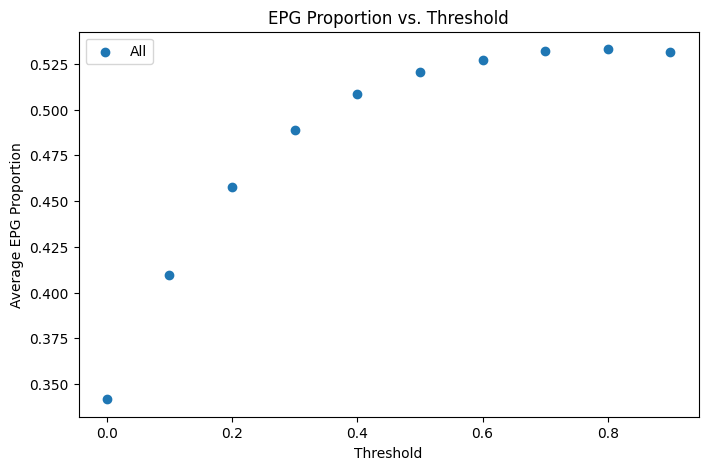

In [4]:
from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 

### alternative in new models
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()  # Normalize with ImageNet stats
])


''' 
transform = no_augmentations() 
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)

'''

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

avg_proportions = []
avg_proportions_incorrect = []
avg_proportions_correct = []

#    model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/ResNet50_FLC/no_nosamp/seed_0/pneumonia_detection_model_resnet_bestf1_{fold}.pth"

for threshold_multiplier in range(0,10):
    model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/ResNet50_FLC/no_nosamp/seed_1/pneumonia_detection_model_resnet_bestf1_3.pth"
    split = splits[2] # fold selection
    val_idx = split[1]  # Only use the validation indices from the first fold
    val_data = data_splits.iloc[val_idx]
    val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


    proportions = []
    proportions_correct = []
    proportions_incorrect = []
    count_correct = 0
    count_incorrect = 0
    
    model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)

    model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
    model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

    model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
    model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

    model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
    model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)    
        
    model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network


    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.to(device)

    model.eval()
    with torch.no_grad():
        for images, labels, patient_ids in val_loader:
            #images, labels = images.to(device), labels.to(device)
            labels = labels.to(device)
            six_channel_images = []
            for img_tensor in images:
                numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                pil_image = Image.fromarray(numpy_image)
                transformed_image = model.transform(pil_image)
                six_channel_images.append(transformed_image)
                
            six_channel_images = torch.stack(six_channel_images).to(device)
            
            
            for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
                filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                if not filtered_rows.empty: 
                    image = image[None]
                    output = model(image)
                    #prediction = torch.argmax(output, dim=1)
                    expl = model.explain(image)
                    prediction = expl['prediction']
                    contribution_map = expl['contribution_map'].squeeze(0).cpu()
                    contribution_map[contribution_map<0] = 0  
                    proportion = 0.0
                    for _, row in filtered_rows.iterrows():
                        x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                        coordinates_list = [x, y, x + width, y + height]
                        coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                        ebpg_result = energy_point_game(coordinates_tensor, contribution_map, threshold=0.1*threshold_multiplier)
                        proportion += ebpg_result
                        
                    proportions.append(proportion)
                    if prediction == 1:
                        proportions_correct.append(proportion)
                        count_correct = count_correct + 1
                    else:
                        proportions_incorrect.append(proportion)
                        count_incorrect = count_incorrect + 1
    if proportions:
        avg_proportion = sum(proportions) / len(proportions)
        avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
        avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
        avg_proportions.append(avg_proportion)
        avg_proportions_incorrect.append(avg_proportion_incorrect)
        avg_proportions_correct.append(avg_proportion_correct)

    avg_proportion = round(avg_proportion.item(), 4)
    avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
    avg_proportion_correct = round(avg_proportion_correct.item(), 4)

    print(f"Threshold: {threshold_multiplier}")
    print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)


final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

final_avg_prop = round(final_avg_prop.item(), 4)
final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
print()
print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)


print(avg_proportions)
# Plotting the result
thresholds = [0.1 * i for i in range(len(avg_proportions))]

plt.figure(figsize=(8, 5))
plt.scatter(thresholds, avg_proportions, marker='o', label='All')
plt.xlabel('Threshold')
plt.ylabel('Average EPG Proportion')
plt.title('EPG Proportion vs. Threshold')
plt.legend()
plt.grid(False)
plt.show()



# Calculate Threshold Recall from 0.1 to 1.0

Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Average Energy-Based Pointing Game Proportion (Positive): 0.9595
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.9233, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.9815, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.6571
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.4503, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.7828, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.4541
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.2137, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.6004, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.3043
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0946, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.432, Count: 748


Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Average Energy-Based Pointing Game Proportion (Positive): 0.1922
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: 0.0385, Count: 455
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: 0.2857, Count: 748

Average Energy-Based Pointing Game Proportion (Positive) over all folds: 0.5134
Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: 0.344
Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: 0.6165
[tensor(0.9595), tensor(0.6571), tensor(0.4541), tensor(0.3043), tensor(0.1922)]


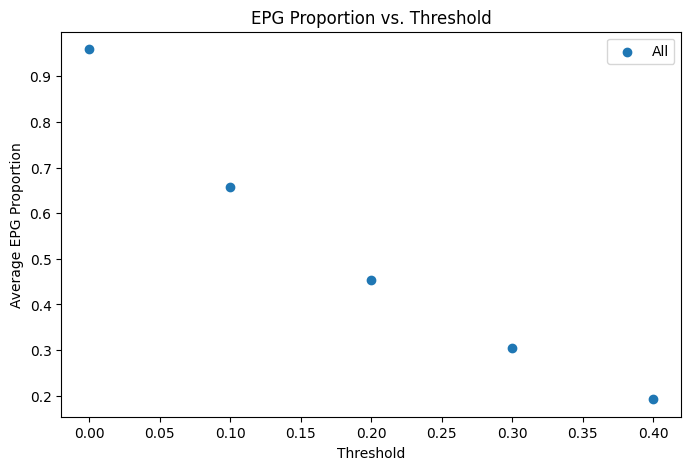

In [3]:
from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d


import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear



np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 

### alternative in new models
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()  # Normalize with ImageNet stats
])


''' 
transform = no_augmentations() 
val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)

'''

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

avg_proportions = []
avg_proportions_incorrect = []
avg_proportions_correct = []

for threshold_multiplier in range(0,5):
    model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/ResNet50_FLC/no_nosamp/seed_1/pneumonia_detection_model_resnet_bestf1_3.pth"
    split = splits[2] # fold selection
    val_idx = split[1]  # Only use the validation indices from the first fold
    val_data = data_splits.iloc[val_idx]
    val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


    proportions = []
    proportions_correct = []
    proportions_incorrect = []
    count_correct = 0
    count_incorrect = 0
    
    model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)

    model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
    model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

    model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
    model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

    model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
    model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)    
        
    model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
    #model = torch.hub.load('B-cos/B-cos-v2', 'vitc_b_patch1_14', pretrained=True)
    #model[0].linear_head.linear = BcosLinear(in_features=768, out_features=2, bias=False, b=2)

    #model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
    #model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.to(device)

    model.eval()
    with torch.no_grad():
        for images, labels, patient_ids in val_loader:
            #images, labels = images.to(device), labels.to(device)
            labels = labels.to(device)
            six_channel_images = []
            for img_tensor in images:
                numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                pil_image = Image.fromarray(numpy_image)
                transformed_image = model.transform(pil_image)
                six_channel_images.append(transformed_image)
                
            six_channel_images = torch.stack(six_channel_images).to(device)
            
            
            for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
                filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                if not filtered_rows.empty: 
                    image = image[None]
                    output = model(image)
                    #prediction = torch.argmax(output, dim=1)
                    expl = model.explain(image)
                    prediction = expl['prediction']
                    contribution_map = expl['contribution_map'].squeeze(0).cpu()
                    proportion_total = 0.0
                    num_boxes = len(filtered_rows)  
                    for _, row in filtered_rows.iterrows():
                        x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                        coordinates_list = [x, y, x + width, y + height]
                        coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                        ebpg_result = energy_point_game_recall(coordinates_tensor, contribution_map, threshold=0.1*threshold_multiplier)
                        proportion_total += ebpg_result
                        
                    average_proportion = proportion_total / num_boxes if num_boxes > 0 else 0.0
                    proportions.append(average_proportion)
                    if prediction == 1:
                        proportions_correct.append(average_proportion)
                        count_correct = count_correct + 1
                    else:
                        proportions_incorrect.append(average_proportion)
                        count_incorrect = count_incorrect + 1
    if proportions:
        avg_proportion = sum(proportions) / len(proportions)
        avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
        avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
        avg_proportions.append(avg_proportion)
        avg_proportions_incorrect.append(avg_proportion_incorrect)
        avg_proportions_correct.append(avg_proportion_correct)

    avg_proportion = round(avg_proportion.item(), 4)
    avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
    avg_proportion_correct = round(avg_proportion_correct.item(), 4)

    print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)


final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

final_avg_prop = round(final_avg_prop.item(), 4)
final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
print()
print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)

thresholds = [0.1 * i for i in range(len(avg_proportions))]

print(avg_proportions)
plt.figure(figsize=(8, 5))
plt.scatter(thresholds, avg_proportions, marker='o', label='All')
plt.xlabel('Threshold')
plt.ylabel('Average EPG Proportion')
plt.title('EPG Proportion vs. Threshold')
plt.legend()
plt.grid(False)
plt.show()

